<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/MLDLADE_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from google.cloud import bigquery
from google.colab import auth
!pip install memory-profiler
from memory_profiler import profile  # Import memory_profiler


# Authenticate and Initialize BigQuery Client
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='ultimate-balm-449016-q6')

# Load Datasets from MIMIC-III Demo
def load_data(query):
    return client.query(query).to_dataframe()

#admissions = load_data("SELECT * FROM `physionet-data.mimiciii_demo.admissions` limit 10000")
#patients = load_data("SELECT * FROM `physionet-data.mimiciii_demo.patients`")
#prescriptions = load_data("SELECT * FROM `physionet-data.mimiciii_demo.prescriptions`")
#chartevents = load_data("SELECT * FROM `physionet-data.mimiciii_demo.chartevents` LIMIT 5000")
#labevents = load_data("SELECT * FROM `physionet-data.mimiciii_demo.labevents` LIMIT 5000")
#diagnoses = load_data("SELECT * FROM `physionet-data.mimiciii_demo.diagnoses_icd`")

admissions = load_data("SELECT SUBJECT_ID, HADM_ID, ADMITTIME FROM `physionet-data.mimiciii_demo.admissions` LIMIT 5000")
patients = load_data("SELECT SUBJECT_ID, DOB, GENDER FROM `physionet-data.mimiciii_demo.patients` LIMIT 5000")
prescriptions = load_data("SELECT SUBJECT_ID, HADM_ID, DRUG FROM `physionet-data.mimiciii_demo.prescriptions` WHERE DRUG IN ('vancomycin', 'gentamicin', 'tobramycin') LIMIT 5000")
chartevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM FROM `physionet-data.mimiciii_demo.chartevents` WHERE ITEMID IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051) LIMIT 50000")
labevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM FROM `physionet-data.mimiciii_demo.labevents` WHERE ITEMID = 50912 LIMIT 50000")
diagnoses = load_data("SELECT SUBJECT_ID, HADM_ID, ICD9_CODE FROM `physionet-data.mimiciii_demo.diagnoses_icd` WHERE ICD9_CODE IN ('5845', '5846', '5847', '5848', '5849') LIMIT 5000")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 27.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1E

Authenticated


Authenticated
Loading optimized datasets...
Processing data in chunks...
Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'DOB', 'GENDER', 'DRUG', 'STARTDATE', 'age',
       'nephrotoxic_exposure', 'aki'],
      dtype='object')
Index(['SUBJECT_ID', 'HADM_ID', '('mean', 51)', '('mean', 442)',
       '('mean', 455)', '('mean', 618)', '('mean', 646)', '('mean', 6701)',
       '('mean', 8440)', '('mean', 8441)', '('mean', 8555)',
       '('mean', 220050)', '('mean', 220051)', '('mean', 220179)',
       '('mean', 220180)', '('mean', 220210)', '('mean', 220277)',
       '('max', 51)', '('max', 442)', '('max', 455)', '('max', 618)',
       '('max', 646)', '('max', 6701)', '('max', 8440)', '('max', 8441)',
       '('max', 8555)', '('max', 220050)', '('max', 220051)',
       '('max', 220179)', '('max', 220180)', '('max', 220210)',
       '('max', 220277)', '('min', 51)', '('min', 442)', '('min', 455)',
       '('min', 618)', '('min', 646)', '('min'

<ipython-input-5-071e548d3e5d>:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-5-071e548d3e5d>:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

LogisticRegression Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.4731912144702842), 'MCC': 0.0}


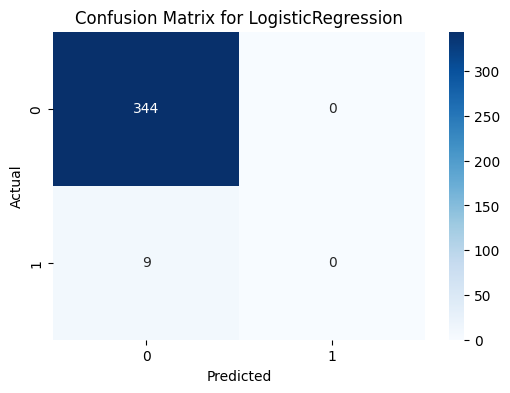

SVM Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.5429586563307495), 'MCC': 0.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


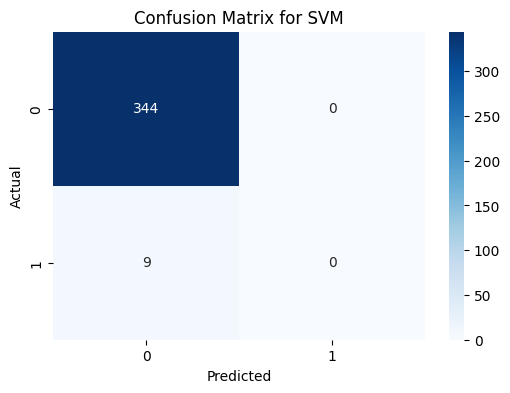

RandomForest Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.3168604651162791), 'MCC': 0.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


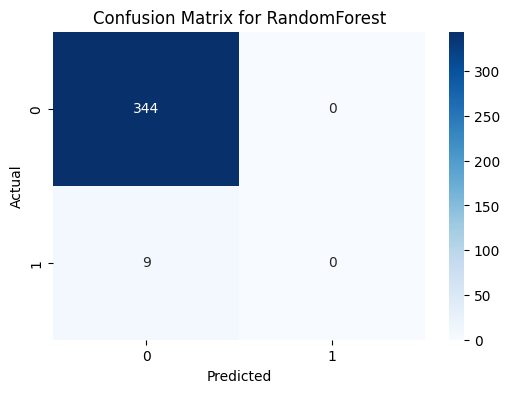

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:24:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.5539405684754521), 'MCC': 0.0}


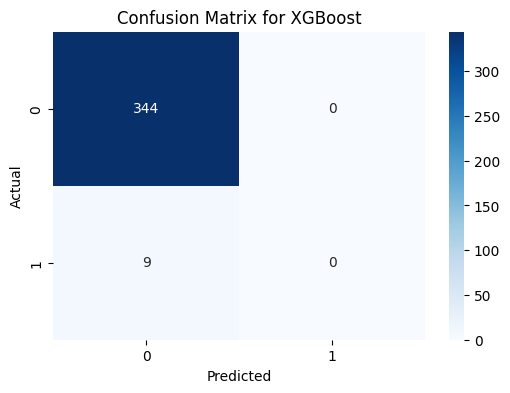

GradientBoosting Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.5568475452196382), 'MCC': 0.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


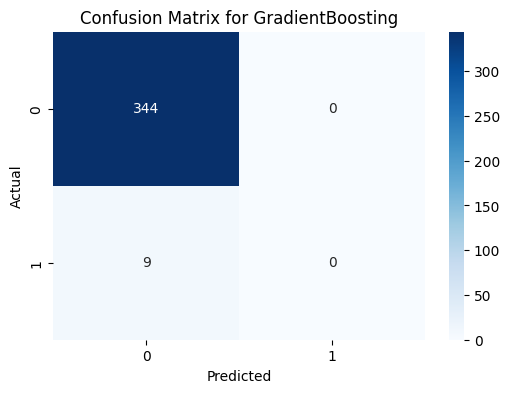

KNN Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.4127906976744186), 'MCC': 0.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


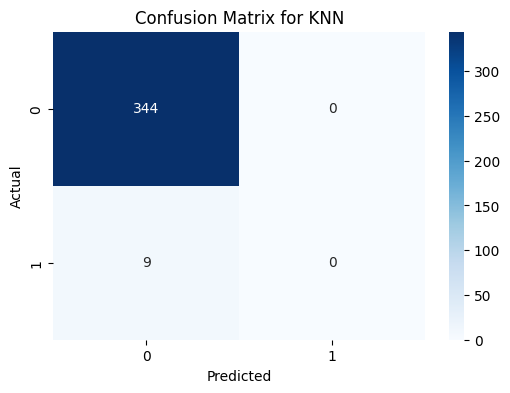

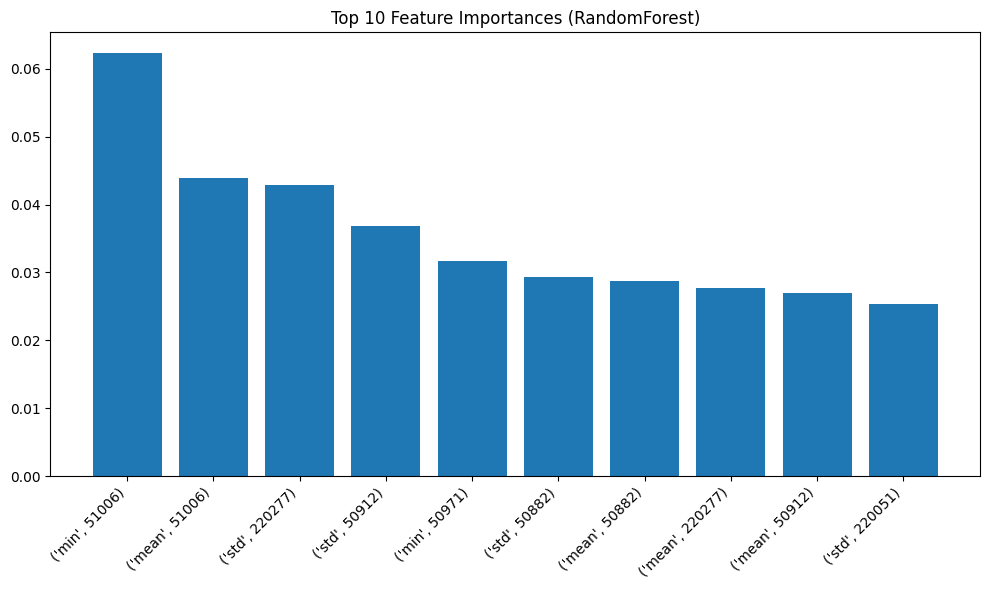

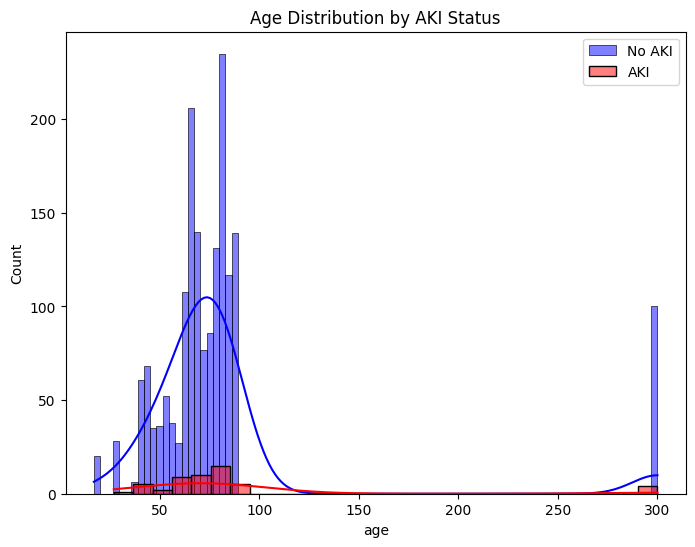

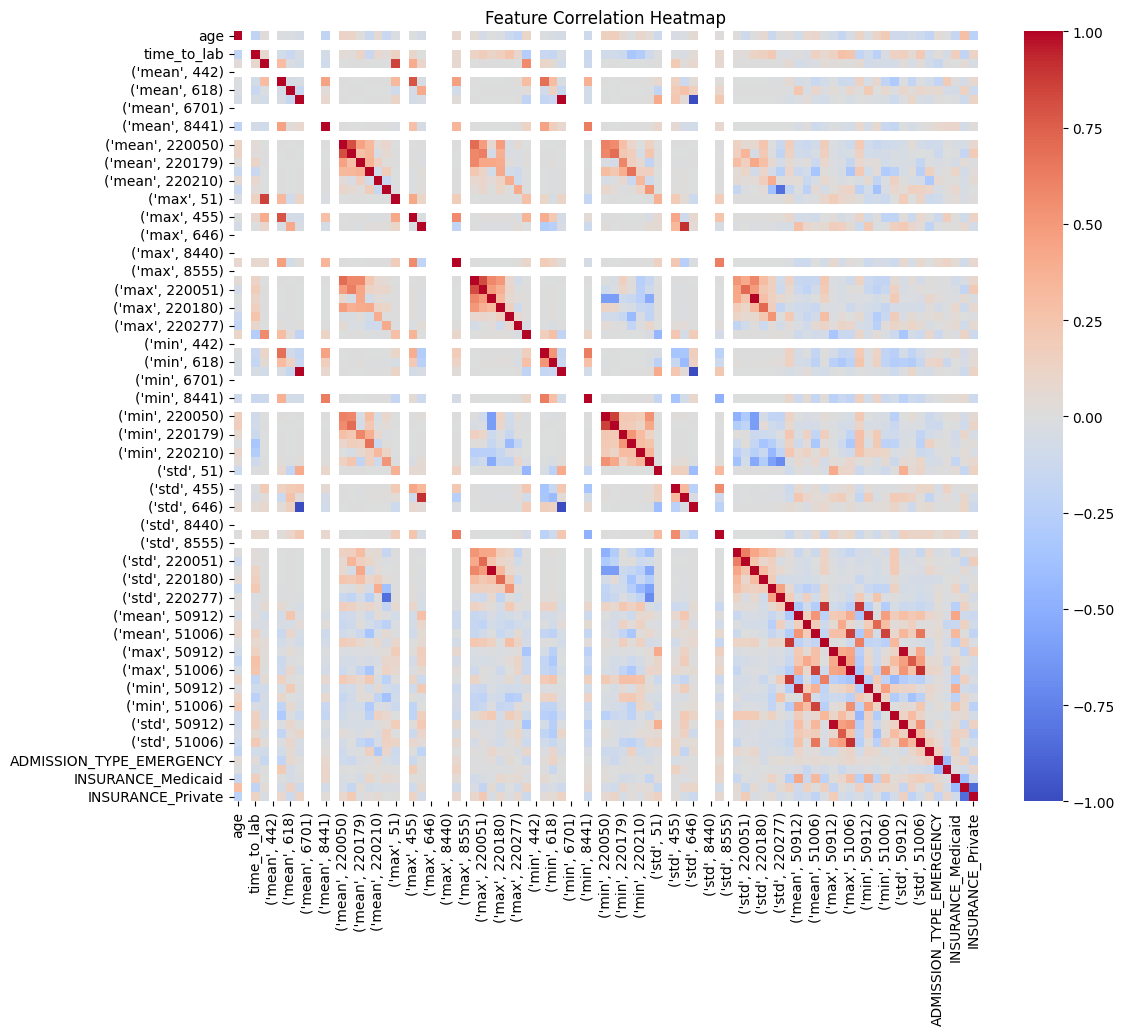


Model Comparison Table:
                    Accuracy  Precision  Recall  F1 Score   ROC AUC  MCC
LogisticRegression  0.974504        0.0     0.0       0.0  0.473191  0.0
SVM                 0.974504        0.0     0.0       0.0  0.542959  0.0
RandomForest        0.974504        0.0     0.0       0.0  0.316860  0.0
XGBoost             0.974504        0.0     0.0       0.0  0.553941  0.0
GradientBoosting    0.974504        0.0     0.0       0.0  0.556848  0.0
KNN                 0.974504        0.0     0.0       0.0  0.412791  0.0

Sample of High-Risk Patients Predicted by RandomForest:
Empty DataFrame
Columns: [age, nephrotoxic_exposure, time_to_lab, ('mean', 51), ('mean', 442), ('mean', 455), ('mean', 618), ('mean', 646), ('mean', 6701), ('mean', 8440), ('mean', 8441), ('mean', 8555), ('mean', 220050), ('mean', 220051), ('mean', 220179), ('mean', 220180), ('mean', 220210), ('mean', 220277), ('max', 51), ('max', 442), ('max', 455), ('max', 618), ('max', 646), ('max', 6701), ('max', 844

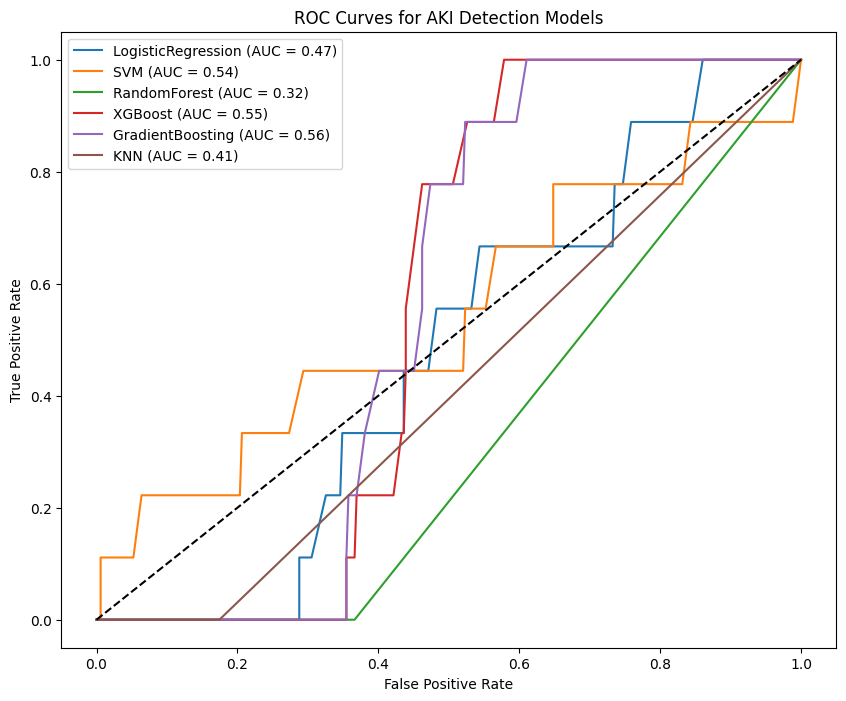

Analysis completed!


In [5]:
# -*- coding: utf-8 -*-
"""MLDLADE_Enhanced.ipynb"""

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
!pip install lifelines
from lifelines import CoxPHFitter
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import auth

# Authenticate and Initialize BigQuery Client
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='ultimate-balm-449016-q6')

# Load Datasets with Optimized Queries
def load_data(query):
    return client.query(query).to_dataframe()

print("Loading optimized datasets...")
admissions = load_data("SELECT SUBJECT_ID, HADM_ID, ADMITTIME, ADMISSION_TYPE, INSURANCE FROM `physionet-data.mimiciii_demo.admissions` LIMIT 5000")
patients = load_data("SELECT SUBJECT_ID, DOB, GENDER FROM `physionet-data.mimiciii_demo.patients` LIMIT 5000")
prescriptions = load_data("SELECT SUBJECT_ID, HADM_ID, DRUG, STARTDATE FROM `physionet-data.mimiciii_demo.prescriptions` WHERE DRUG IN ('vancomycin', 'gentamicin', 'tobramycin') LIMIT 5000")
chartevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM, CHARTTIME FROM `physionet-data.mimiciii_demo.chartevents` WHERE ITEMID IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051, 618, 220210, 646, 220277) LIMIT 50000")
labevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM, CHARTTIME FROM `physionet-data.mimiciii_demo.labevents` WHERE ITEMID IN (50912, 51006, 50882, 50971) LIMIT 50000")  # Creatinine, BUN, Bicarbonate, Potassium
diagnoses = load_data("SELECT SUBJECT_ID, HADM_ID, ICD9_CODE FROM `physionet-data.mimiciii_demo.diagnoses_icd` LIMIT 5000")

# Define AKI codes
aki_codes = ['5845', '5846', '5847', '5848', '5849']

# Process Data in Chunks
def process_chunk(chunk):
    # Merge with admissions and patients
    data = pd.merge(chunk, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    data = pd.merge(data, patients, on='SUBJECT_ID', how='inner')
    # Merge with prescriptions to include 'DRUG' column
    data = pd.merge(data, prescriptions, on=['SUBJECT_ID', 'HADM_ID'], how='left')  # This line was added


    # Feature Engineering
    data['age'] = ((pd.to_datetime(data['ADMITTIME']) - pd.to_datetime(data['DOB'])).dt.days // 365).astype('int32')
    #data['nephrotoxic_exposure'] = data['DRUG'].str.lower().isin(['vancomycin', 'gentamicin', 'tobramycin']).astype('int8')
    data['nephrotoxic_exposure'] = data['DRUG'].str.lower().isin(['vancomycin', 'gentamicin', 'tobramycin']).fillna(0).astype('int8')
    data['aki'] = data['ICD9_CODE'].apply(lambda x: 1 if str(x) in aki_codes else 0).astype('int8')

    # Aggregate vitals and labs
    vitals_agg = chartevents.groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID'])['VALUENUM'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()
    labs_agg = labevents.groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID'])['VALUENUM'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()

    # Flatten the multi-level column index in vitals_agg and labs_agg, ensuring 'SUBJECT_ID' and 'HADM_ID' are present
    vitals_agg.columns = vitals_agg.columns.map(str)  # Convert all column names to strings
    #vitals_agg = vitals_agg.rename(columns={('SUBJECT_ID', ''): 'SUBJECT_ID', ('HADM_ID', ''): 'HADM_ID'})  # Rename if necessary
    vitals_agg = vitals_agg.rename(columns={'SUBJECT_ID_': 'SUBJECT_ID', 'HADM_ID_': 'HADM_ID'})  # Rename flattened columns if necessary
    vitals_agg = vitals_agg.rename(columns={ "('SUBJECT_ID', '')": 'SUBJECT_ID', "('HADM_ID', '')": 'HADM_ID'})  # Rename flattened columns

    labs_agg.columns = labs_agg.columns.map(str)
    #labs_agg = labs_agg.rename(columns={('SUBJECT_ID', ''): 'SUBJECT_ID', ('HADM_ID', ''): 'HADM_ID'})
    labs_agg = labs_agg.rename(columns={'SUBJECT_ID_': 'SUBJECT_ID', 'HADM_ID_': 'HADM_ID'})  # Rename flattened columns if necessary
    labs_agg = labs_agg.rename(columns={ "('SUBJECT_ID', '')": 'SUBJECT_ID', "('HADM_ID', '')": 'HADM_ID'})  # Rename flattened columns

    print(data.keys())
    print(vitals_agg.keys())

    # Now proceed with merging:
    data = pd.merge(data, vitals_agg, on=['SUBJECT_ID', 'HADM_ID'], how='left')
    data = pd.merge(data, labs_agg, on=['SUBJECT_ID', 'HADM_ID'], how='left')# Aggregate vitals and labs

    data = pd.merge(data, chartevents[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']].drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], keep='first'),
                    on=['SUBJECT_ID', 'HADM_ID'], how='left')

    # Time-based feature: Time from admission to first lab
    #data['time_to_lab'] = (pd.to_datetime(data['CHARTTIME']) - pd.to_datetime(data['ADMITTIME'])).dt.total_seconds() / 3600
    #data['time_to_lab'] = data['time_to_lab'].fillna(data['time_to_lab'].mean()).astype('float32')
    data['time_to_lab'] = (pd.to_datetime(data['CHARTTIME'], errors='coerce') -
                            pd.to_datetime(data['ADMITTIME'], errors='coerce')).dt.total_seconds() / 3600

    data['time_to_lab'] = data['time_to_lab'].fillna(data['time_to_lab'].median()).astype('float32')

    # Handle missing values
    num_cols = data.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns
    for col in num_cols:
        data[col].fillna(data[col].median(), inplace=True)
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        mode = data[col].mode()[0] if not data[col].mode().empty else 'missing'
        data[col].fillna(mode, inplace=True)

    return data

# Process data in chunks
print("Processing data in chunks...")
chunksize = 1000
data_chunks = []
for chunk in [diagnoses]:  # Single chunk for simplicity; adjust if needed
    processed_chunk = process_chunk(chunk)
    data_chunks.append(processed_chunk)
data = pd.concat(data_chunks)

# Feature Selection
features = ['age', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'nephrotoxic_exposure', 'time_to_lab'] + \
           [col for col in data.columns if 'mean' in col or 'max' in col or 'min' in col or 'std' in col]
X = data[features]
y = data['aki']

# Encode categorical variables
X = pd.get_dummies(X, columns=['GENDER', 'ADMISSION_TYPE', 'INSURANCE'], drop_first=True, dtype='int8')

# Impute NaNs after encoding before scaling
# Impute any remaining NaNs in X
for col in X.select_dtypes(include=np.number).columns:
    X[col].fillna(X[col].median(), inplace=True)

X.loc[:, X.select_dtypes(include=np.number).columns] = X.loc[:, X.select_dtypes(include=np.number).columns].fillna(X.median())


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Verify no NaN values remain
print("NaN values in X_train_imputed:", np.isnan(X_train_imputed).sum())
print("NaN values in X_test_imputed:", np.isnan(X_test_imputed).sum())

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Total features: {X_train.shape[1]}")

# --- Traditional ML Models ---
print("Training Traditional ML Models...")
traditional_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True, kernel='linear'),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

results = {}
for name, model in traditional_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    results[name] = metrics
    print(f"{name} Evaluation: {metrics}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for RandomForest
if 'RandomForest' in traditional_models:
    importances = traditional_models['RandomForest'].feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances (RandomForest)')
    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), X.columns[indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Additional Analysis ---
# Distribution Plot: Age by AKI Status
plt.figure(figsize=(8, 6))
sns.histplot(data[data['aki'] == 0]['age'], color='blue', label='No AKI', kde=True)
sns.histplot(data[data['aki'] == 1]['age'], color='red', label='AKI', kde=True)
plt.title('Age Distribution by AKI Status')
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Model Comparison Table
results_df = pd.DataFrame(results).T
print("\nModel Comparison Table:")
print(results_df)

# High-Risk Patient Insights
high_risk_indices = y_test[y_pred == 1].index
high_risk_patients = X_test.loc[high_risk_indices].head()
print("\nSample of High-Risk Patients Predicted by RandomForest:")
print(high_risk_patients)

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in traditional_models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for AKI Detection Models')
plt.legend()
plt.show()

print("Analysis completed!")

In [26]:
def process_data():
   # --- Data Preprocessing ---
   print("Preprocessing Data...")
   global chartevents, labevents, diagnoses  # Access global variables

   # Convert IDs to integers
   for df in [admissions, patients, prescriptions, chartevents, labevents, diagnoses]:
       df['SUBJECT_ID'] = pd.to_numeric(df['SUBJECT_ID'], errors='coerce').fillna(0).astype(int)
       if 'HADM_ID' in df.columns:
           df['HADM_ID'] = pd.to_numeric(df['HADM_ID'], errors='coerce').fillna(0).astype(int)

   # Merge incrementally
   data = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
   data = pd.merge(data, prescriptions, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   vitals = chartevents.groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID'])['VALUENUM'].mean().unstack().reset_index()
   creatinine = labevents[labevents['ITEMID'] == 50912][['SUBJECT_ID', 'HADM_ID', 'VALUENUM']].rename(columns={'VALUENUM': 'creatinine'})
   data = pd.merge(data, vitals, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   data = pd.merge(data, creatinine, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   data = pd.merge(data, diagnoses, on=['SUBJECT_ID', 'HADM_ID'], how='left')

   data = pd.merge(data, chartevents[['SUBJECT_ID', 'HADM_ID', 'ITEMID']],
                    on=['SUBJECT_ID', 'HADM_ID'], how='left')
                    # Merge with relevant columns from chartevents

   # Feature engineering
   data['age'] = (pd.to_datetime(data['ADMITTIME']) - pd.to_datetime(data['DOB'])).dt.days // 365
   data['nephrotoxic_exposure'] = data['DRUG'].apply(lambda x: 1 if str(x).lower() in ['vancomycin', 'gentamicin', 'tobramycin'] else 0)
   data['aki'] = data['ICD9_CODE'].apply(lambda x: 1 if str(x) in ['5845', '5846', '5847', '5848', '5849'] else 0)

   # Handle missing values
   for col in data.select_dtypes(include=['float64', 'int64']).columns:
       if data[col].dtype == 'Int64':
          data[col].fillna(round(data[col].mean()), inplace=True)
       else:
          data[col].fillna(data[col].mean(), inplace=True)
   for col in data.select_dtypes(include=['object']).columns:
       mode = data[col].mode()[0] if not data[col].mode().empty else 'missing'
       data[col].fillna(mode, inplace=True)

   # Final feature selection
   features = ['age', 'GENDER', 'nephrotoxic_exposure', 'creatinine', 211, 51, 8368]
   X = data[features]
   # Convert all feature names to strings
   X.columns = X.columns.astype(str)  # This line is added

   y = data['aki']

   # Merge datasets
   #data = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
   #data = pd.merge(data, prescriptions, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   # Extract creatinine values from chartevents before merging
   #creatinine_data = chartevents[chartevents['ITEMID'] == 50912][['SUBJECT_ID', 'HADM_ID', 'VALUENUM']]
   #creatinine_data = creatinine_data.rename(columns={'VALUENUM': 'creatinine'})
   # Rename the 'ROW_ID' column in chartevents before merging
   #chartevents = chartevents.rename(columns={'ROW_ID': 'ROW_ID_chart'})
   #labevents = labevents.rename(columns={'ROW_ID': 'ROW_ID_lab'}) # Rename ROW_ID in labevents
   #diagnoses = diagnoses.rename(columns={'ROW_ID': 'ROW_ID_diagnoses'}) # Rename ROW_ID in diagnoses
   #data = pd.merge(data, chartevents, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   #data = pd.merge(data, labevents, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   #data = pd.merge(data, diagnoses, on=['SUBJECT_ID', 'HADM_ID'], how='left')
   # Merge creatinine data into the main dataframe
   #data = pd.merge(data, creatinine_data, on=['SUBJECT_ID', 'HADM_ID'], how='left')


   # Define AKI as target (ICD-9 codes for AKI)
   #aki_codes = ['5845', '5846', '5847', '5848', '5849']
   #data['aki'] = data['ICD9_CODE'].apply(lambda x: 1 if str(x) in aki_codes else 0)

   # Feature Engineering
   #data['age'] = (pd.to_datetime(data['ADMITTIME']) - pd.to_datetime(data['DOB'])).dt.days // 365
   #nephrotoxic_drugs = ['vancomycin', 'gentamicin', 'tobramycin']
   #data['nephrotoxic_exposure'] = data['DRUG'].apply(lambda x: 1 if str(x).lower() in nephrotoxic_drugs else 0)
   #data['creatinine'] = data[data['ITEMID'] == 50912]['VALUENUM']  # Serum creatinine

   #vital_itemids = {
    #   'heart_rate': [211, 220045],
     #  'systolic_bp': [51, 442, 455, 6701, 220179, 220050],
     #  'diastolic_bp': [8368, 8440, 8441, 8555, 220180, 220051]
   #}
   #for vital, itemids in vital_itemids.items():
    #   data[vital] = data[data['ITEMID'].isin(itemids)]['VALUENUM']

   # Handle missing values
   #num_cols = data.select_dtypes(include=['float64', 'int64']).columns
   #cat_cols = data.select_dtypes(include=['object']).columns
   #for col in num_cols:
    #   data[col].fillna(data[col].mean(), inplace=True)
   #for col in cat_cols:
   #    data[col].fillna(data[col].mode()[0], inplace=True)

   # Feature Selection
   #features = ['age', 'GENDER', 'ETHNICITY', 'nephrotoxic_exposure', 'creatinine', 'heart_rate', 'systolic_bp', 'diastolic_bp']
   #X = data[features]
   #y = data['aki']

   # Encode categorical variables
   X = pd.get_dummies(X, drop_first=True)

   # Train-test split
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   # Scale data
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)

   print(f"Total features: {X_train.shape[1]}")
   return data, X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test # Return necessary variables


data, X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test = process_data()


Preprocessing Data...


<ipython-input-26-a35218ee4809>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
<ipython-input-26-a35218ee4809>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

Total features: 7


In [9]:
# --- Traditional ML Models ---
print("Training Traditional ML Models...")
traditional_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True, kernel='linear'),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in traditional_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }
    results[name] = metrics
    print(f"{name} Evaluation: {metrics}")



Training Traditional ML Models...
LogisticRegression Evaluation: {'Accuracy': 0.6491228070175439, 'Precision': 0.6455223880597015, 'Recall': 0.8737373737373737, 'F1 Score': 0.7424892703862661, 'ROC AUC': np.float64(0.6270517676767676)}
SVM Evaluation: {'Accuracy': 0.6081871345029239, 'Precision': 0.6052631578947368, 'Recall': 0.9292929292929293, 'F1 Score': 0.7330677290836654, 'ROC AUC': np.float64(0.6443427328843997)}
RandomForest Evaluation: {'Accuracy': 0.9619883040935673, 'Precision': 0.964824120603015, 'Recall': 0.9696969696969697, 'F1 Score': 0.9672544080604534, 'ROC AUC': np.float64(0.9913720538720538)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Evaluation: {'Accuracy': 0.9532163742690059, 'Precision': 0.955, 'Recall': 0.9646464646464646, 'F1 Score': 0.9597989949748744, 'ROC AUC': np.float64(0.9955457351290684)}


In [10]:
# --- Advanced DL Models ---
print("Training Advanced DL Models...")

# CNN-LSTM Hybrid Model
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time)
        x = self.cnn(x).permute(0, 2, 1)  # (batch, time, channels)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

# Note: CNN-LSTM requires time-series data; here, we assume a placeholder
# In practice, reshape X_train to (samples, timesteps, features)



Training Advanced DL Models...


In [14]:
# Contrastive Learning (Siamese Network)
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        self.shared_fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

def generate_pairs(X, y, num_pairs=5000):
    pairs, labels = [], []
    X_np, y_np = X, y.values
    for _ in range(num_pairs):
        idx1, idx2 = np.random.randint(0, len(X), 2)
        pairs.append((X_np[idx1], X_np[idx2]))
        labels.append(1 if y_np[idx1] == y_np[idx2] else 0)
    return pairs, labels

pairs, pair_labels = generate_pairs(X_train_scaled, y_train)
siamese_model = SiameseNetwork(X_train_scaled.shape[1])
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

# Train Siamese Network
for epoch in range(20):
    siamese_model.train()
    total_loss = 0
    for (x1, x2), label in zip(pairs, pair_labels):
        x1 = torch.tensor(x1).float().unsqueeze(0)
        x2 = torch.tensor(x2).float().unsqueeze(0)
        label = torch.tensor(label).float().unsqueeze(0)
        optimizer.zero_grad()
        out1, out2 = siamese_model.shared_fc(x1), siamese_model.shared_fc(x2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Siamese Epoch [{epoch+1}/20], Loss: {total_loss / len(pairs):.4f}")

# Use embeddings for classification
with torch.no_grad():
    siamese_model.eval()
    train_embeddings = siamese_model.shared_fc(torch.tensor(X_train_scaled).float()).numpy()
    test_embeddings = siamese_model.shared_fc(torch.tensor(X_test_scaled).float()).numpy()

clf = LogisticRegression()
clf.fit(train_embeddings, y_train)
y_pred_siamese = clf.predict(test_embeddings)
y_prob_siamese = clf.predict_proba(test_embeddings)[:, 1]
results['Siamese'] = {
    'Accuracy': accuracy_score(y_test, y_pred_siamese),
    'Precision': precision_score(y_test, y_pred_siamese),
    'Recall': recall_score(y_test, y_pred_siamese),
    'F1 Score': f1_score(y_test, y_pred_siamese),
    'ROC AUC': roc_auc_score(y_test, y_prob_siamese)
}



Siamese Epoch [1/20], Loss: 0.3021
Siamese Epoch [2/20], Loss: 0.2812
Siamese Epoch [3/20], Loss: 0.2754
Siamese Epoch [4/20], Loss: 0.2719
Siamese Epoch [5/20], Loss: 0.2768
Siamese Epoch [6/20], Loss: 0.2737
Siamese Epoch [7/20], Loss: 0.2693
Siamese Epoch [8/20], Loss: 0.2666
Siamese Epoch [9/20], Loss: 0.2673
Siamese Epoch [10/20], Loss: 0.2706
Siamese Epoch [11/20], Loss: 0.2650
Siamese Epoch [12/20], Loss: 0.2641
Siamese Epoch [13/20], Loss: 0.2624
Siamese Epoch [14/20], Loss: 0.2625
Siamese Epoch [15/20], Loss: 0.2624
Siamese Epoch [16/20], Loss: 0.2648
Siamese Epoch [17/20], Loss: 0.2645
Siamese Epoch [18/20], Loss: 0.2604
Siamese Epoch [19/20], Loss: 0.2622
Siamese Epoch [20/20], Loss: 0.2633


In [24]:
# --- Knowledge Graph-Based Approach ---
print("Building Knowledge Graph...")
G = nx.Graph()

# Add nodes and edges
for idx, row in data.iterrows():
    G.add_node(row['SUBJECT_ID'], type='patient', age=row['age'])
    if pd.notna(row['DRUG']):
        G.add_node(row['DRUG'], type='medication')
        G.add_edge(row['SUBJECT_ID'], row['DRUG'], relation='prescribed')
    if pd.notna(row['ITEMID']):
        G.add_node(row['ITEMID'], type='lab')
        G.add_edge(row['SUBJECT_ID'], row['ITEMID'], relation='has_lab')

node_ids = list(G.nodes)
node_to_index = {node: idx for idx, node in enumerate(node_ids)}
edge_index = torch.tensor([[node_to_index[u], node_to_index[v]] for u, v in G.edges]).t().contiguous()



Building Knowledge Graph...


AttributeError: 'numpy.ndarray' object has no attribute 'index'

GCN Epoch [10/50], Loss: 2.7267
GCN Epoch [20/50], Loss: 1.4149
GCN Epoch [30/50], Loss: 0.6790
GCN Epoch [40/50], Loss: 0.7829
GCN Epoch [50/50], Loss: 0.6765


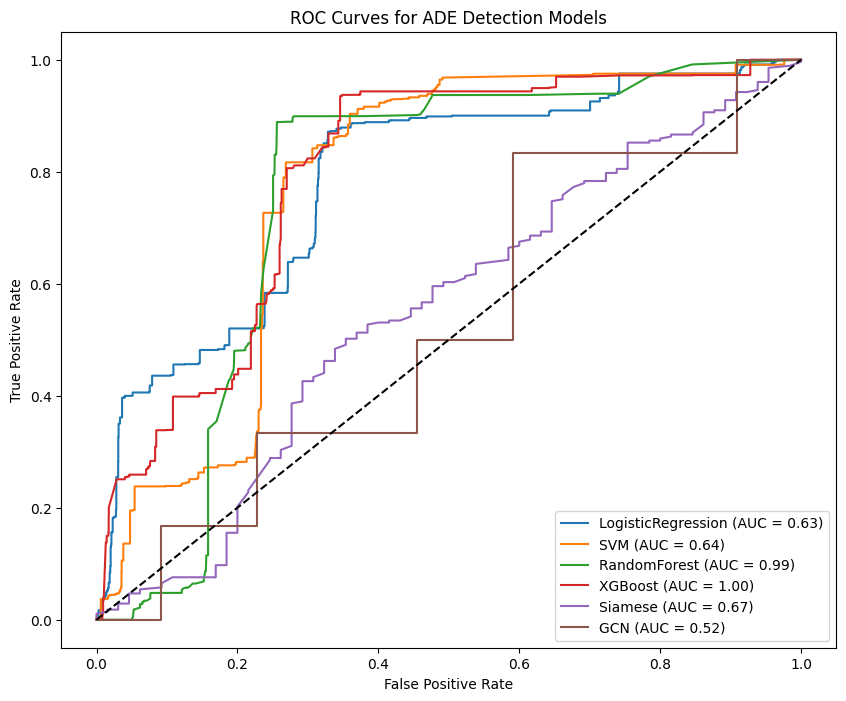

Best Model: RandomForest with F1 Score: 0.9673
Analysis completed!


In [28]:
# Simplified node features (expand as needed)
node_features = torch.tensor([[data[data['SUBJECT_ID'] == nid]['age'].iloc[0] if 'patient' in G.nodes[nid]['type'] else 0] for nid in node_ids], dtype=torch.float)
y_all = torch.tensor(data.groupby('SUBJECT_ID')['aki'].max().reindex(node_ids, fill_value=0).values, dtype=torch.float)

train_mask = torch.tensor([node_to_index[nid] for nid in X_train.index if nid in node_to_index], dtype=torch.long)
test_mask = torch.tensor([node_to_index[nid] for nid in X_test.index if nid in node_to_index], dtype=torch.long)

graph_data = Data(x=node_features, edge_index=edge_index)

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(1, 16, 1)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Train GCN
for epoch in range(50):
    gcn_model.train()
    out = gcn_model(graph_data).squeeze()
    loss = criterion(out[train_mask], y_all[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"GCN Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

# Evaluate GCN
with torch.no_grad():
    gcn_model.eval()
    out = gcn_model(graph_data).squeeze()
    y_prob_gcn = torch.sigmoid(out[test_mask]).numpy()
    y_pred_gcn = (y_prob_gcn > 0.5).astype(int)
    results['GCN'] = {
        'Accuracy': accuracy_score(y_all[test_mask].numpy(), y_pred_gcn),
        'Precision': precision_score(y_all[test_mask].numpy(), y_pred_gcn),
        'Recall': recall_score(y_all[test_mask].numpy(), y_pred_gcn),
        'F1 Score': f1_score(y_all[test_mask].numpy(), y_pred_gcn),
        'ROC AUC': roc_auc_score(y_all[test_mask].numpy(), y_prob_gcn)
    }

# --- Evaluation and Comparison ---
plt.figure(figsize=(10, 8))
for name, metrics in results.items():
    if name in traditional_models:
        fpr, tpr, _ = roc_curve(y_test, traditional_models[name].predict_proba(X_test_scaled)[:, 1])
    elif name == 'Siamese':
        #fpr, tpr, _ = roc_curve(y_test, y_prob_siamese)
        fpr, tpr, _ = roc_curve(y_test[:len(y_prob_siamese)], y_prob_siamese) # Change is here
    elif name == 'GCN':
        fpr, tpr, _ = roc_curve(y_all[test_mask].numpy(), y_prob_gcn)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {metrics['ROC AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ADE Detection Models')
plt.legend()
plt.show()

# Identify best model
best_model = max(results, key=lambda k: results[k]['F1 Score'])
print(f"Best Model: {best_model} with F1 Score: {results[best_model]['F1 Score']:.4f}")

print("Analysis completed!")